# Chapter 7: Fine-Tuning to Follow Instructions

## 7.2 Preparing a Dataset for Instruction Fine-Tuning

We need to download and format the instruction dataset for instruction fine-tuning a pretrained LLM.

In [1]:
import json
import os
import requests

def download_and_load_file(filepath, url):
    if not os.path.exists(filepath):
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        text_data = response.text

        with open(filepath, 'w', encoding='utf-8') as f:
            f.write(text_data)

    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)

    return data

In [2]:
filepath = 'instruction-data.json'
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/instruction-data.json"

data = download_and_load_file(filepath, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [3]:
print("Example entry:\n", data[0])

Example entry:
 {'instruction': 'Evaluate the following phrase by transforming it into the spelling given.', 'input': 'freind --> friend', 'output': 'The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".'}


In [4]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


Instruction fine-tuning involves training a model on a dataset where the input-output pairs are explicitly provided.

There are two different example formats, referred to as *prompt styles*, used in the trianing of LLMs, such as Alpaca and Phi-3.
- The *Alpaca* style uses a structured format with defined sections for instruction, input, and response:
    ```
    Below is an instruction that describes a task. Write a response that appropriately completes the request.

    ### Instruction:
    Identify the correct spelling of the following word.

    ### Input:
    Ocassion

    ### Response:
    The correct spelling is 'Occasion'.
    ```
- The *Phi-3* style uses a conversational format with designated `<|user|>` and `<|assistant|>` tokens:
    ```
    <|user|> 
    Identify the correct spelling of the following word: 'Ocassion'

    <|assistant|>
    The correct spelling is 'Occasion'.
    ```

In this chapter, we will use the Alpaca-style format for instruction fine-tuning.

In [5]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry['input'] else ""

    return instruction_text + input_text

In [6]:
model_input = format_input(data[0])
desired_output = f"\n\n### Response:\n{data[0]['output']}"

print(model_input + desired_output)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend

### Response:
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".


In [7]:
# data without input field
model_input = format_input(data[999])
desired_output = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_output)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


In [8]:
# Split the dataset
train_portion = int(len(data) * 0.85) # 85% for training
test_portion = int(len(data) * 0.10)  # 10% for testing
val_portion = len(data) - train_portion - test_portion  # 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set size:", len(train_data))
print("Testing set size:", len(test_data))
print("Validation set size:", len(val_data))

Training set size: 935
Testing set size: 110
Validation set size: 55


## 7.3 Organizing Data into Training Batches

The next step is to build the training batches effectively. In previous chapters, the training batches were created automatically with the `DataLoader` class from PyTorch, which employs a default *collate function* to combine lists of samples into batches.

A collate function is responsible for taking a list of data samples and merging them into a single batch that can be processed by the model during training.

For our instruction fine-tuning task, we need to implement a custom collate function that can handle the specific structure of our instruction dataset.

First, we need to define a `Dataset` class that can load and preprocess our instruction data.

In [9]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize text
        self.encoded_texts = []

        for entry in self.data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text

            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]
    
    def __len__(self):
        return len(self.data)

In [10]:
# Similarly as before, we use `gpt2` tokenizer and add special tokens
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


Then we will adopt a more sophisticated approach by developing a custom collate function that we can pass to the dataloader.

This custom collate function pads the training examples in each batch to the same length while allowing different batches to have different lengths. This approach minimizes unnecessary padding by only extending sequences to match the longest sequence in each batch, not the longest sequence in the entire dataset.

In [11]:
def custom_collate_draft_1(
        batch,
        pad_token_id=50256,
        device='cpu'
):
    # Find the longest sequence in the batch
    # and increase by 1 for padding
    batch_max_length = max(len(item) + 1 for item in batch)

    # Pad the prepare inputs
    inputs_list = []

    for item in batch:
        new_item = item.copy()
        # Pad sequences to `batch_max_length`
        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )

        # Via `padded[:-1]`, we remove the extra padded tokens
        # that have been added via the +1 setting in `batch_max_length`
        # (the extra padding tokens will be relevant in later steps)
        inputs = torch.tensor(padded[:-1])
        inputs_list.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_list).to(device)

    return inputs_tensor

In [12]:
# Test
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = [inputs_1, inputs_2, inputs_3]

print("Batch before collation:\n", batch)
collated_batch = custom_collate_draft_1(batch)
print("Collated batch:\n", collated_batch)
print("Collated batch shape:", collated_batch.shape)


Batch before collation:
 [[0, 1, 2, 3, 4], [5, 6], [7, 8, 9]]
Collated batch:
 tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
Collated batch shape: torch.Size([3, 5])


The `custom_collate_draft_1` function creates batches from lists of inputs. We also need to create batches with the target token IDs corresponding to the batch of input IDs. Similar to the process we used to pretrain an LLM, the target token IDs match the input token IDs but are shifted one position to the right, allowing the LLM to learn how to predict the next token in a sequence.

In [13]:
def custom_collate_draft_2(
        batch,
        pad_token_id=50256,
        device='cpu'
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item) + 1 for item in batch)

    # Pad the prepare inputs
    inputs_list, targets_list = [], []

    for item in batch:
        new_item = item.copy()

        # Add an `<|endoftext|>` token at the end of each sequence
        new_item += [pad_token_id]
        # Pad sequences to `batch_max_length`
        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        # Truncate the last token for inputs
        inputs = torch.tensor(padded[:-1])
        # Shift one position to the right for targets
        targets = torch.tensor(padded[1:])

        inputs_list.append(inputs)
        targets_list.append(targets)

    # Convert list of inputs/targets to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_list).to(device)
    targets_tensor = torch.stack(targets_list).to(device)

    return inputs_tensor, targets_tensor

In [14]:
# Test the same batch with the new collate function
collated_inputs, collated_targets = custom_collate_draft_2(batch)
print("Collated inputs:\n", collated_inputs)
print("Collated inputs shape:", collated_inputs.shape)
print("Collated targets:\n", collated_targets)
print("Collated targets shape:", collated_targets.shape)

Collated inputs:
 tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
Collated inputs shape: torch.Size([3, 5])
Collated targets:
 tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])
Collated targets shape: torch.Size([3, 5])


Next, we will assign a `-100` placeholder value to all padding tokens. Thhis special valuue allows us to exclude these padding tokens from contributing to the training loss calculation, ensuring that only meaningful data influences model learning.

We only retain one `<|endoftext|>` token, ID `50256`, in the target list. Retaining it allows the LLM to learn when to generate an end-of-text token in response to instructions, which we use as an indicator that the generated resopnse is complete.

In the following `custom_collate_fn` function, we modify and replace tokens with ID `50256` with `-100` in the target lists.

In addition, we introduce an `allowed_max_length` parameter to optionally limit the length of the samples. This will be useful if we plan to work with our own dataset that exceed the 1024-token context size supported by the GPT-2 model we are using for instruction fine-tuning.

In [15]:
def custom_collate_fn(
        batch,
        pad_token_id=50256,
        ignore_index=-100,
        allowed_max_length=None,
        device='cpu'
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item) + 1 for item in batch)

    # Pad the prepare inputs and targets
    inputs_list, targets_list = [], []

    for item in batch:
        new_item = item.copy()

        # Add an `<|endoftext|>` token at the end of each sequence
        new_item += [pad_token_id]
        # Pad sequences to `batch_max_length`
        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )

        # Truncate the last token for inputs
        inputs = torch.tensor(padded[:-1])
        # Shift one position to the right for targets
        targets = torch.tensor(padded[1:])

        # NEW: Replace all but the first padding tokens in targets by `ignore_index`
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # NEW: Optionally truncate sequences to `allowed_max_length`
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_list.append(inputs)
        targets_list.append(targets)

    # Convert list of inputs/targets to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_list).to(device)
    targets_tensor = torch.stack(targets_list).to(device)

    return inputs_tensor, targets_tensor

In [16]:
# Test the same batch with the new collate function
collated_inputs, collated_targets = custom_collate_fn(batch)
print("Collated inputs:\n", collated_inputs)
print("Collated inputs shape:", collated_inputs.shape)
print("Collated targets:\n", collated_targets)
print("Collated targets shape:", collated_targets.shape)

Collated inputs:
 tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
Collated inputs shape: torch.Size([3, 5])
Collated targets:
 tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])
Collated targets shape: torch.Size([3, 5])


Consider the following exampple where each output logit corresponds to a potential token from the model's vocabulary. We can calculate the cross entropy loss during training when the model predicts a sequence of tokens:

In [17]:
logits_1 = torch.tensor(
    [[-1., 1.],   # 1st training example
     [-0.5, 1.5]] # 2nd training example
)
targets_1 = torch.tensor([0, 1])

loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print("Loss 1:", loss_1.item())

Loss 1: 1.1269280910491943


If we add an additional token ID, it would affect the loss calculation:

In [18]:
logits_2 = torch.tensor(
    [[-1., 1.],
     [-0.5, 1.5],
     [-0.5, 1.5]] # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print("Loss 2:", loss_2.item())

Loss 2: 0.7935947775840759


If we set the additional token ID to `-100`, it will be ignored in the loss calculation:

In [19]:
# logits_3 starts the same
logits_3 = torch.tensor(
    [[-1., 1.],
     [-0.5, 1.5],
     [-0.5, 1.5]]
)

targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_3, targets_3)
print("Loss 3:", loss_3.item())

Loss 3: 1.1269280910491943


The resulting loss only considers the valid token predictions, effectively ignoring the padding token.

By default, PyTorch has the `cross_entropy` setting `ignore_index=-100`, which means that any target token with the value `-100` will be excluded from the loss computation. Using `-100` `ignore_index`, we can ignore the additional end-of-text tokens in the batches that we used to pad the training examples to equal lengths.

However, we do not want to ignore the first instance of the end-of-text token because it can help signal to the LLM when the response is complete.

## 7.4 Creating Dataloaders for an Instruction Dataset

The `custom_collate_fn` function includes a `device` parameter that moves the input and target tensors to a specified device, such as a GPU, for efficient training.

Previously we moved the data onto the target device in the main training loopp. Having this as part of the collate function allows us to transfer the data as a background processs outside the training loop, preventing it from blocking the GPU during model training.

In [20]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print("Device:", device)

Device: cpu


To reuse the chosen device setting in `custom_collate_fn`, we can use the `partial` function from the `functools` module to create a new version of the collate function with the device parameter set to the desired device.

In [21]:
from functools import partial

custom_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

Next, we set up the dataloader as we did previously, but this time we will use our customized collate function.

In [22]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(0)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=custom_collate_fn,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=custom_collate_fn,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=custom_collate_fn,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False
)

In [23]:
print("Train loader:")
for inputs, targets in train_loader:
    print("Inputs shape:", inputs.shape)
    print("Targets shape:", targets.shape)

Train loader:
Inputs shape: torch.Size([8, 59])
Targets shape: torch.Size([8, 59])
Inputs shape: torch.Size([8, 65])
Targets shape: torch.Size([8, 65])
Inputs shape: torch.Size([8, 69])
Targets shape: torch.Size([8, 69])
Inputs shape: torch.Size([8, 73])
Targets shape: torch.Size([8, 73])
Inputs shape: torch.Size([8, 62])
Targets shape: torch.Size([8, 62])
Inputs shape: torch.Size([8, 60])
Targets shape: torch.Size([8, 60])
Inputs shape: torch.Size([8, 71])
Targets shape: torch.Size([8, 71])
Inputs shape: torch.Size([8, 60])
Targets shape: torch.Size([8, 60])
Inputs shape: torch.Size([8, 80])
Targets shape: torch.Size([8, 80])
Inputs shape: torch.Size([8, 76])
Targets shape: torch.Size([8, 76])
Inputs shape: torch.Size([8, 74])
Targets shape: torch.Size([8, 74])
Inputs shape: torch.Size([8, 62])
Targets shape: torch.Size([8, 62])
Inputs shape: torch.Size([8, 68])
Targets shape: torch.Size([8, 68])
Inputs shape: torch.Size([8, 58])
Targets shape: torch.Size([8, 58])
Inputs shape: torch.

All batches have a batch size of 8 but a different sequence length depending on the longest sequence in each batch as expected.

We also need to check the `<|endoftext|>` token in the target batches to ensure that only one instance of this token is present in each target sequence.

In [24]:
print("Example input sequence:")
print(inputs[0])

print("Example target sequence:")
print(targets[0])

Example input sequence:
tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 15946,   485,   257,  1573,   326,  9529,
        22009,   351,   366,  6651,   526,   198,   198, 21017, 18261,    25,
          198,    32,  1573,   326,  9529, 22009,   351,   366,  6651,     1,
          318,   366,  9496,   526, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256])
Example target sequence:
tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 15946,   485,   257,  1573,   326,  9529, 22009,
          351,   366,  6651,   526,   198,   198, 21017, 18261,    25,   198,
           32,  1573,   326,  9529, 22009,   351,   366,  6651,     1,   318,
          366,  9496,   526, 50256,  -100,

## 7.5 Loading a Pretrained LLM

We need to load the medium-sized GPT-2 model with 355M parameters as our base LLM for instruction fine-tuning because the small GPT-2 model with 124M parameters may not have sufficient capacity to effectively learn and generalize from the instruction dataset. The storage of the medium-sized model is approximately 1.5GB, which is about three times larger than the small model's size of approximately 500MB.

In [25]:
from llms_from_scratch.ch04 import GPTModel
from llms_from_scratch.ch05 import download_and_load_gpt2, load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

c:\Repos\build_a_large_language_model_from_scratch\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 117kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 1.85MiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 92.4kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [01:47<00:00, 13.2MiB/s]
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 12.6MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:00<00:00, 2.63MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.76MiB/s]


We need to test the performance of the medium-sized GPT-2 model on our instruction dataset

In [26]:
torch.manual_seed(0)

input_text = format_input(data[0])
print("Sample input text:\n", input_text)

Sample input text:
 Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend


In [27]:
from llms_from_scratch.ch05 import generate, text_to_token_ids, token_ids_to_text

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=100,
    context_size=BASE_CONFIG['context_length'],
    eos_id=50256
)

generated_text = token_ids_to_text(token_ids, tokenizer)

The `generate` function returns the combined input and output text, which is convenient in the previous section for creating legible text.

Now we need to separate the generated output text from the input prompt to evaluate the model's responses accurately.

In [28]:
response_text = generated_text[len(input_text):].replace("### Response:", "").strip()
print("Generated response:\n", response_text)

Generated response:
 ### Output:

freind --> friend

### Instruction:

Evaluate the following phrase by transforming it into the spelling given.

### Input:

freind --> friend

### Output:

freind --> friend

### Instruction:

Evaluate the following phrase by transforming it into the spelling given.

### Input:

freind --> friend

### Output:

freind --> friend

###


## 7.6 Fine-Tuning the LLM on Instruction Data

For the fine-tuning process, we will reuse the loss calculation and training functions implemented in Chapter 5.

In [29]:
from llms_from_scratch.ch05 import calc_loss_loader, train_model_simple

In [30]:
# Calculate initial losses
model.to(device)

torch.manual_seed(0)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print(f"Initial train loss: {train_loss:.4f}")
print(f"Initial val loss: {val_loss:.4f}")

Initial train loss: 3.8946
Initial val loss: 3.7619


In [31]:
# Train the model
import time

start_time = time.time()

torch.manual_seed(0)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context=format_input(val_data[0]),
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.583, Val loss 2.556
Ep 1 (Step 000005): Train loss 0.965, Val loss 1.093
Ep 1 (Step 000010): Train loss 0.857, Val loss 0.959
Ep 1 (Step 000015): Train loss 0.831, Val loss 0.914
Ep 1 (Step 000020): Train loss 0.728, Val loss 0.883
Ep 1 (Step 000025): Train loss 0.776, Val loss 0.854
Ep 1 (Step 000030): Train loss 0.783, Val loss 0.839
Ep 1 (Step 000035): Train loss 0.707, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.715, Val loss 0.790
Ep 1 (Step 000045): Train loss 0.751, Val loss 0.777
Ep 1 (Step 000050): Train loss 0.710, Val loss 0.763
Ep 1 (Step 000055): Train loss 0.646, Val loss 0.741
Ep 1 (Step 000060): Train loss 0.566, Val loss 0.727
Ep 1 (Step 000065): Train loss 0.576, Val loss 0.726
Ep 1 (Step 000070): Train loss 0.535, Val loss 0.718
Ep 1 (Step 000075): Train loss 0.595, Val loss 0.715
Ep 1 (Step 000080): Train loss 0.544, Val loss 0.711
Ep 1 (Step 000085): Train loss 0.495, Val loss 0.697
Ep 1 (Step 000090): Train loss 0.486, Val loss

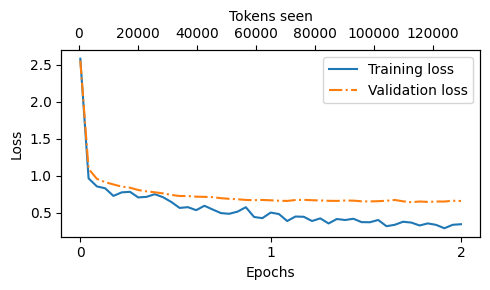

In [32]:
from llms_from_scratch.ch05 import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## 7.7 Extracting and Saving Responses

Now we are ready to evaluate the fine-tuned LLM on the instruction dataset by extracting the model-generated responses for each input in the test dataset and collecting them for manual analysis, and then evaluating the LLM to quantify the quality of the responses.

In [33]:
torch.manual_seed(0)

for entry in test_data[:3]:
    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG['context_length'],
        eos_id=50256
    )

    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A thunderstorm is a type of cloud that typically forms in the atmosphere at altitudes of at least 10 kilometers.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Mod

Model evaluation for instruction fine-tuning is not as straightforward as the perplexity metric used for LLM pretraining or the classification accuracy metric used for discriminative tasks.

In practice, instruction-fine-tuned LLMs such as chatbots are evaluted via multiple approaches:
- Short-answer and multiple-choice benchmarks, such as *Measuring Massive Multitask Language Understanding* (MMLU), which test the general knowledge of a model.
- Human preference comparison to other LLMs, such as LMSYS chatbot arena.
- Automated conversational benchmarks, where another LLM like GPT-4 is used to evaluate the responses, such as AlpacaEval.

In practice, it can be helpful to consider all three types of evaluation methods: multiple-choice question answering, human evaluation, and automated metrics that measure conversational performance.

For demo purposes, we will implement an approach similar to automated conversational benchmarks, which involves evaluating the responses automatically using another LLM.

We will use our own test dataset for evaluation, so we need to prepare the responses for this evalution process. We will append the generated model responses to the `test_set` dictionary and save the updated data as an `instruction-data-with-response.json` file for record keeping.

In [34]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG['context_length'],
        eos_id=50256
    )

    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]['model_response'] = response_text

with open('instruction-data-with-responses.json', 'w') as f:
    json.dump(test_data, f, indent=4)

100%|██████████| 110/110 [04:48<00:00,  2.62s/it]


In [35]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


Save the model:

In [ ]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

In [ ]:
# Load model via
model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

## 7.8 Evaluating the Fine-Tuned LLM

To evaluate test set responses in an automated manner, we will use an instruction-fine-tuned 8M parameter Llama-3 model.

In [ ]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

In [ ]:
# This cell is optional; it allows you to restart the notebook
# and only run section 7.7 without rerunning any of the previous code
import json
from tqdm import tqdm

file_path = "instruction-data-with-response.json"

with open(file_path, "r") as file:
    test_data = json.load(file)


def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [ ]:
import requests  # noqa: F811
# import urllib.request

def query_model(
    prompt,
    model="llama3",
    # If you used OLLAMA_HOST=127.0.0.1:11435 ollama serve
    # update the address from 11434 to 11435
    url="http://localhost:11434/api/chat"
):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }

    
    """
    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data
    """

    # The book originally used the commented-out above, which is based
    # on urllib. It works generally fine, but some readers reported
    # issues with using urlib when using a (company) VPN.
    # The code below uses the requests library, which doesn't seem
    # to have these issues.

    # Send the POST request
    with requests.post(url, json=data, stream=True, timeout=30) as r:
        r.raise_for_status()
        response_data = ""
        for line in r.iter_lines(decode_unicode=True):
            if not line:
                continue
            response_json = json.loads(line)
            if "message" in response_json:
                response_data += response_json["message"]["content"]

    return response_data


model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

In [ ]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")

In [ ]:
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores


scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")